<a href="https://colab.research.google.com/github/imhyadav/customer-segmentation-dashboard/blob/main/Customer_Segmentation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving customer_transactions_1000_15cols.csv to customer_transactions_1000_15cols.csv


In [ ]:
df = pd.read_csv('customer_transactions_1000_15cols.csv', parse_dates=['InvoiceDate','CustomerSince'])
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   InvoiceNo      1000 non-null   object        
 1   InvoiceDate    1000 non-null   datetime64[ns]
 2   CustomerID     1000 non-null   object        
 3   CustomerSince  1000 non-null   datetime64[ns]
 4   Country        1000 non-null   object        
 5   PaymentMethod  1000 non-null   object        
 6   Channel        1000 non-null   object        
 7   StockCode      1000 non-null   object        
 8   Description    1000 non-null   object        
 9   Category       1000 non-null   object        
 10  SubCategory    1000 non-null   object        
 11  Quantity       1000 non-null   int64         
 12  UnitPrice      1000 non-null   float64       
 13  DiscountPct    1000 non-null   float64       
 14  PromoCode      322 non-null    object        
 15  TotalAmount    1000 no

,InvoiceNo,InvoiceDate,CustomerID,CustomerSince,Country,PaymentMethod,Channel,StockCode,Description,Category,SubCategory,Quantity,UnitPrice,DiscountPct,PromoCode,TotalAmount
0,INV100521,2024-04-16 12:20:16,C1128,2019-01-25,United Kingdom,Debit Card,Online,P013,Backpack,Accessories,Bags,2,96.99,0.0,NaN,193.980
1,INV100737,2023-12-29 08:14:27,C1116,2018-11-12,United States,Debit Card,Online,P013,Backpack,Accessories,Bags,3,96.99,0.0,NaN,290.970
2,INV100740,2023-04-22 12:36:13,C1276,2018-09-21,United Kingdom,Credit Card,Online,P007,Headphones,Electronics,Audio,4,53.87,0.0,WELCOME5,215.480
3,INV100660,2024-12-13 21:44:50,C1339,2021-01-18,United States,Credit Card,Online,P007,Headphones,Electronics,Audio,1,53.87,0.0,NEW10,53.870
4,INV100411,2024-10-02 01:07:40,C1252,2018-05-29,United States,Credit Card,Online,P020,HDMI Cable,Electronics,Accessories,2,145.37,0.2,NaN,232.592


In [ ]:
# Check missing values
df.isna().sum()

# If any CustomerID missing, drop those rows (can't compute RFM without CustomerID)
df = df.dropna(subset=['CustomerID'])

# Convert types if needed
df['Quantity'] = df['Quantity'].astype(int)
df['UnitPrice'] = df['UnitPrice'].astype(float)
df['DiscountPct'] = df['DiscountPct'].astype(float)

# Optional: filter out returns (negative quantities) if you want only purchases
df = df[df['Quantity'] > 0].copy()


In [ ]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date.date())


Snapshot date: 2024-12-31


In [ ]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm.describe().round(0)


,Recency,Frequency,Monetary
count,366.0,366.0,366.0
mean,347.0,3.0,595.0
std,280.0,1.0,453.0
min,1.0,1.0,14.0
25%,114.0,1.0,225.0
50%,276.0,3.0,508.0
75%,520.0,4.0,858.0
max,1093.0,8.0,2894.0


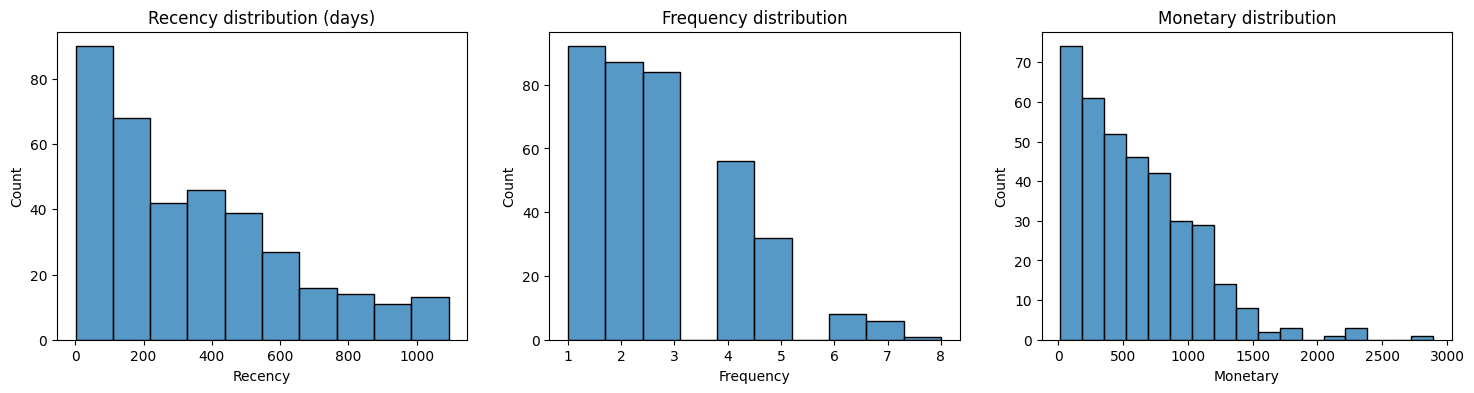

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18,4))
sns.histplot(rfm['Recency'], ax=axes[0], kde=False)
axes[0].set_title('Recency distribution (days)')

sns.histplot(rfm['Frequency'], ax=axes[1], kde=False)
axes[1].set_title('Frequency distribution')

sns.histplot(rfm['Monetary'], ax=axes[2], kde=False)
axes[2].set_title('Monetary distribution')
plt.show()


In [ ]:
scaler = StandardScaler()
features = ['Recency_log','Frequency_log','Monetary_log']
rfm_scaled = scaler.fit_transform(rfm[features])


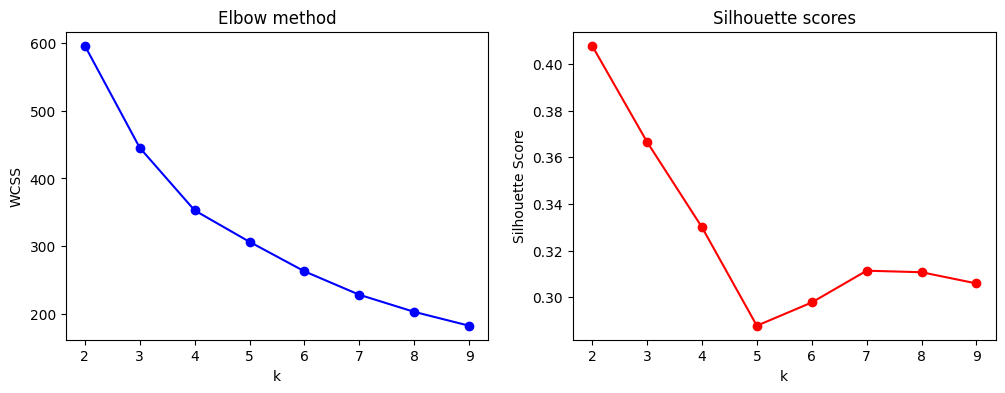

In [ ]:
wcss = []
sil_scores = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(rfm_scaled)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

# Plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bo-')
plt.xlabel('k'); plt.ylabel('WCSS'); plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, 'ro-')
plt.xlabel('k'); plt.ylabel('Silhouette Score'); plt.title('Silhouette scores')
plt.show()


In [ ]:
best_k = 4  # choose based on previous step
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [ ]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': ['median','mean'],
    'Frequency': ['median','mean'],
    'Monetary': ['median','mean'],
    'CustomerID': 'count'
}).round(0)

cluster_profile.columns = ['Recency_med','Recency_mean','Frequency_med','Frequency_mean','Monetary_med','Monetary_mean','Customer_count']
cluster_profile = cluster_profile.sort_values('Monetary_med', ascending=False)
cluster_profile


,Recency_med,Recency_mean,Frequency_med,Frequency_mean,Monetary_med,Monetary_mean,Customer_count
Cluster,,,,,,,
0,198.0,238.0,4.0,4.0,912.0,964.0,145
2,14.0,16.0,3.0,3.0,568.0,678.0,32
3,415.0,426.0,2.0,2.0,369.0,418.0,115
1,556.0,580.0,1.0,1.0,102.0,111.0,74


In [ ]:
def label_cluster(row):
    if row['Recency_med'] < 30 and row['Frequency_med'] > 3 and row['Monetary_med'] > 200:
        return 'Loyal'
    # (adjust thresholds based on your cluster_profile)
    return 'Other'

# This is illustrative; instead assign labels manually after inspecting cluster_profile.


In [ ]:
rfm_export = rfm[['CustomerID','Recency','Frequency','Monetary','Cluster']]
rfm_export.to_csv('rfm_customers_1000_clusters.csv', index=False)
print("Saved rfm_customers_1000_clusters.csv")


Saved rfm_customers_1000_clusters.csv


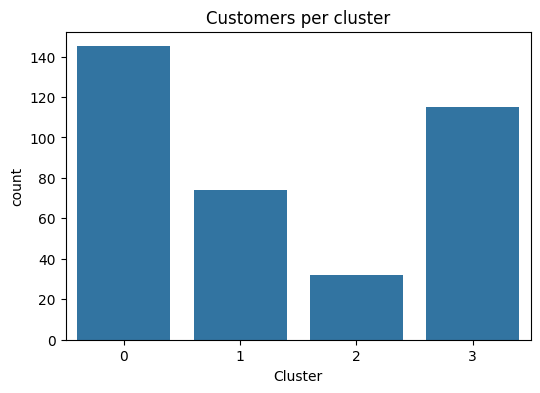

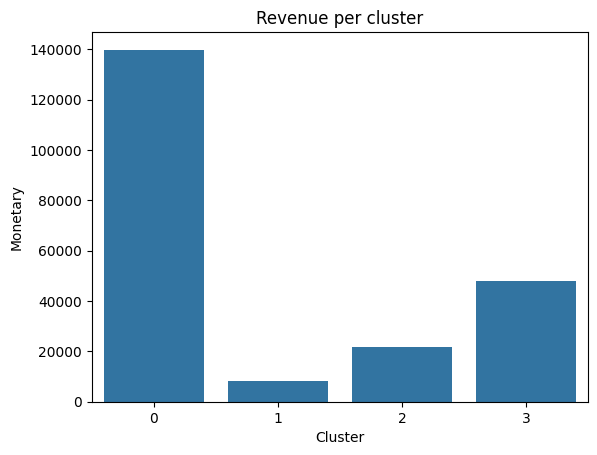

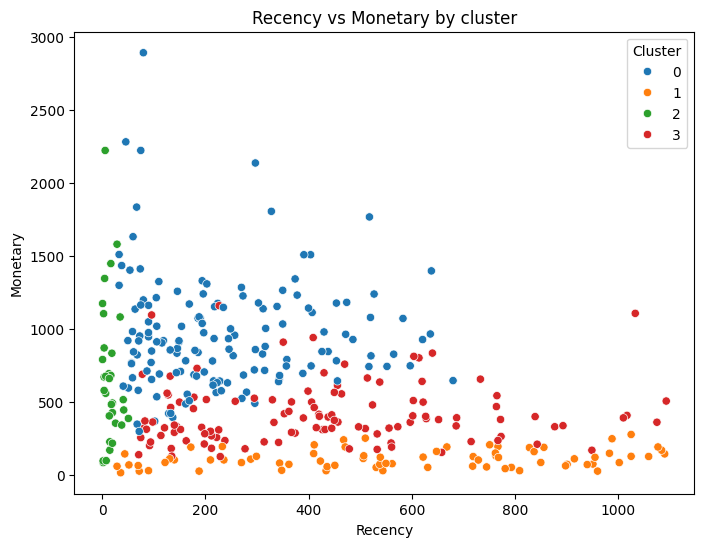

In [ ]:
# Count per cluster
plt.figure(figsize=(6,4))
sns.countplot(x='Cluster', data=rfm)
plt.title('Customers per cluster')
plt.show()

# Monetary sum per cluster
cluster_money = rfm.groupby('Cluster')['Monetary'].sum().reset_index()
sns.barplot(x='Cluster', y='Monetary', data=cluster_money)
plt.title('Revenue per cluster')
plt.show()

# Scatter Recency vs Monetary colored by cluster
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title('Recency vs Monetary by cluster')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save to your Google Drive
rfm.to_csv('/content/drive/MyDrive/rfm_customers_clusters_output.csv', index=False)


Mounted at /content/drive
